In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.stats import zscore, linregress
from pandas.plotting import scatter_matrix
from scipy import stats
import numpy as np

In [2]:
# Function to remove outliers from a dataframe
from sklearn.neighbors import LocalOutlierFactor

def remove_outliers(df):
    # Initialize a boolean mask to keep track of rows to drop
    outlier_rows_mask = np.zeros(len(df), dtype=bool)

    # Iterate over each column
    for col in df.columns:
        # Fit the LocalOutlierFactor model to the column data
        lof = LocalOutlierFactor()
        outliers = lof.fit_predict(df[col].values.reshape(-1, 1))

        # Mark rows with outliers in this column
        outlier_rows_mask = np.logical_or(outlier_rows_mask, outliers == -1)

    # Drop rows with outliers
    # cleaned_df = df[~outlier_rows_mask]
    return outlier_rows_mask

In [3]:
fluxnet_info = pd.read_csv("../data/EC/fluxnet/sites_info.csv")
ameriflux_info = pd.read_csv("../data/EC/Ameriflux/sites_info.tsv", delimiter="\t")

In [4]:
fluxnet_names = fluxnet_info["ID"].to_list()
fluxnet_types = fluxnet_info["type"].to_list()
ameriflux_names = ameriflux_info["Site ID"].to_list()
ameriflux_types = ameriflux_info["Vegetation Abbreviation (IGBP)"].to_list()

In [5]:
combined_names = list(set(ameriflux_names + fluxnet_names))
combined_types = []
for name in combined_names:
    if name in ameriflux_names and name in fluxnet_names:
        # Choose a type from either fluxnet_types or ameriflux_types
        combined_types.append(fluxnet_types[fluxnet_names.index(name)])
    elif name in ameriflux_names:
        combined_types.append(ameriflux_types[ameriflux_names.index(name)])
    else:
        combined_types.append(fluxnet_types[fluxnet_names.index(name)])

In [6]:
dfs = []

# Iterate over the range of length of 'name' column in sites_info
for i in range(len(combined_names)):
    site_name = combined_names[i]
    site_type = combined_types[i]

    # Set the file path based on whether the combined name is in ameriflux_names or fluxnet_names
    if site_name in ameriflux_names:
        file = glob.glob("../data/EC/Ameriflux/AMF_" + site_name + "*DD*")
    else:
        file = glob.glob("../data/EC/fluxnet/FLX_" + site_name + "*DD*")

    # Open the CSV file
    ec = pd.read_csv(file[0])
    ec.loc[:, "type"] = site_type
    ec.loc[:, "name"] = site_name

    ec["t"] = pd.to_datetime(ec["TIMESTAMP"], format="%Y%m%d")
    ec = ec.set_index("t")

    # Append the DataFrame to the list
    dfs.append(ec)

# Concatenate all DataFrames in the list
combined_ec = pd.concat(dfs)

Combine all the satellite data


In [7]:
MCD43_fluxnet = []
MCD15_fluxnet = []
MCD43_ameriflux = []
MCD15_ameriflux = []

# Loop over batches (#5) of downloaded data
for i in range(1, 5):
    refl_fluxnet = glob.glob(
        "../data/EC/fluxnet/sat_data/*batch" + str(i) + "*MCD43A4-061-results.csv"
    )
    sat_refl_fluxnet = pd.read_csv(refl_fluxnet[0])
    sat_refl_fluxnet.loc[:, "time"] = pd.to_datetime(sat_refl_fluxnet["Date"])
    sat_refl_fluxnet.set_index(sat_refl_fluxnet["Date"], inplace=True)
    MCD43_fluxnet.append(sat_refl_fluxnet)

    fpar_fluxnet = glob.glob(
        "../data/EC/fluxnet/sat_data/*batch" + str(i) + "*MCD15A3H-061-results.csv"
    )
    sat_fpar_fluxnet = pd.read_csv(fpar_fluxnet[0])
    sat_fpar_fluxnet.loc[:, "time"] = pd.to_datetime(sat_fpar_fluxnet["Date"])
    sat_fpar_fluxnet.set_index(sat_fpar_fluxnet["Date"], inplace=True)
    MCD15_fluxnet.append(sat_fpar_fluxnet)

    if i < 5:
        refl_ameriflux = glob.glob(
            "../data/EC/Ameriflux/sat_data/*batch" + str(i) + "*MCD43A4-061-results.csv"
        )

        sat_refl_ameriflux = pd.read_csv(refl_ameriflux[0])
        sat_refl_ameriflux.loc[:, "time"] = pd.to_datetime(sat_refl_ameriflux["Date"])
        sat_refl_ameriflux.set_index(sat_refl_ameriflux["Date"], inplace=True)
        MCD43_ameriflux.append(sat_refl_ameriflux)

        fpar_ameriflux = glob.glob(
            "../data/EC/Ameriflux/sat_data/*batch"
            + str(i)
            + "*MCD15A3H-061-results.csv"
        )
        fpar_ameriflux = pd.read_csv(fpar_ameriflux[0])

        fpar_ameriflux.loc[:, "time"] = pd.to_datetime(fpar_ameriflux["Date"])
        fpar_ameriflux.set_index(fpar_ameriflux["Date"], inplace=True)
        MCD15_ameriflux.append(fpar_ameriflux)


refl_fluxnet = pd.concat(MCD43_fluxnet)
refl_fluxnet = refl_fluxnet.rename(columns={"ID": "name"})

fpar_fluxnet = pd.concat(MCD15_fluxnet)
fpar_fluxnet = fpar_fluxnet.rename(columns={"ID": "name"})

refl_ameriflux = pd.concat(MCD43_ameriflux)
refl_ameriflux = refl_ameriflux.rename(columns={"ID": "name"})
fpar_ameriflux = pd.concat(MCD15_ameriflux)
fpar_ameriflux = fpar_ameriflux.rename(columns={"ID": "name"})

In [8]:
combined_refl = []
combined_fpar = []

for name in combined_names:
    if name in ameriflux_names:
        selected_refl = refl_ameriflux[refl_ameriflux["name"] == name]
        selected_fpar = fpar_ameriflux[fpar_ameriflux["name"] == name]
    else:
        selected_refl = refl_fluxnet[refl_fluxnet["name"] == name]
        selected_fpar = fpar_fluxnet[fpar_fluxnet["name"] == name]

    combined_refl.append(selected_refl)
    combined_fpar.append(selected_fpar)

combined_refl = pd.concat(combined_refl)
combined_fpar = pd.concat(combined_fpar)

In [97]:
bad_sites_list = []
df_stat = []
df_stat_pft = []

for i in range(len(combined_names)):
    print(i)
    site_name = combined_names[i]
    site_type = combined_types[i]
    selected_ec = combined_ec[combined_ec["name"] == site_name]

    if selected_ec["PPFD_IN_QC"].isna().all():
        print("No PPFD data for " + site_name)
        bad_sites_list.append(site_name)
        continue
    gpp = selected_ec[["GPP_NT_VUT_REF"]]
    par = selected_ec[["PPFD_IN"]]
    par_qc = selected_ec[["PPFD_IN_QC"]]
    ec_daily = pd.concat([gpp, par, par_qc], axis=1).rename(
        columns={"GPP_NT_VUT_REF": "gpp", "PPFD_IN": "par", "PPFD_IN_QC": "par_qc"}
    )
    ec_daily = ec_daily[ec_daily["par_qc"] == 1]
    ec_daily = ec_daily[ec_daily["gpp"] != -9999]

    # filter fpar based on QC flags
    filtered_fpar = selected_fpar[
        (selected_fpar["MCD15A3H_061_FparLai_QC_MODLAND"] == "0b0")
        & (selected_fpar["MCD15A3H_061_FparLai_QC_DeadDetector"] == "0b0")
        & (selected_fpar["MCD15A3H_061_FparLai_QC_CloudState"] == "0b00")
        & (selected_fpar["MCD15A3H_061_FparLai_QC_SCF_QC"].isin(["0b000", "0b001"]))
    ].copy()

    filtered_fpar.loc[:, "time"] = pd.to_datetime(filtered_fpar["Date"])
    fpar_4days = filtered_fpar[["MCD15A3H_061_Fpar_500m"]]
    fpar_4days.set_index(filtered_fpar["time"], inplace=True)
    fpar_daily = fpar_4days.resample("D").interpolate(method="linear")
    fpar_daily.rename(columns={"MCD15A3H_061_Fpar_500m": "fpar"}, inplace=True)
    if len(fpar_daily) < 30:
        print("Not enough fpar for" + site_name)
        bad_sites_list.append(site_name)
        continue

    # Now filter reflectance
    filtered_refl = selected_refl[
        (
            selected_refl[
                "MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band1_MODLAND"
            ]
            == "0b000"
        )
        & (
            selected_refl[
                "MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band2_MODLAND"
            ]
            == "0b000"
        )
    ].copy()
    filtered_refl.loc[:, "time"] = pd.to_datetime(filtered_refl["Date"])
    red_daily = filtered_refl[["MCD43A4_061_Nadir_Reflectance_Band1"]]
    nir_daily = filtered_refl[["MCD43A4_061_Nadir_Reflectance_Band2"]]

    refl_daily = pd.concat([red_daily, nir_daily], axis=1).rename(
        {
            "MCD43A4_061_Nadir_Reflectance_Band1": "red",
            "MCD43A4_061_Nadir_Reflectance_Band2": "nir",
        },
        axis=1,
    )
    refl_daily.set_index(filtered_refl["time"], inplace=True)
    daily_df = ec_daily.merge(refl_daily, left_index=True, right_index=True).merge(
        fpar_daily, left_index=True, right_index=True
    )
    daily_df.loc[:, "ndvi"] = (daily_df["nir"] - daily_df["red"]) / (
        daily_df["nir"] + daily_df["red"]
    )
    daily_df.loc[:, "nirv"] = daily_df["ndvi"] * daily_df["nir"]
    daily_df.loc[:, "nirvp"] = daily_df["nirv"] * daily_df["par"]
    daily_df.loc[:, "fesc"] = daily_df["nirv"] / daily_df["fpar"]
    daily_df.loc[:, "dasf"] = daily_df["nirv"] / 0.9789

    daily_df.loc[:, "lue"] = daily_df["gpp"] / (daily_df["par"] * daily_df["fpar"])
    daily_df = daily_df.replace([-np.inf, np.inf], np.nan).dropna()

    selected_ec_years = daily_df.index.year.unique()
    if len(selected_ec_years) < 3:
        print("Not enough years for " + site_name)
        bad_sites_list.append(site_name)
        continue

    outlier_rows_mask = remove_outliers(daily_df)
    df_no_outliers = daily_df[~outlier_rows_mask].copy()
    df_stat_pft.append(site_type)

    # max_lue_index = df_no_outliers["lue"].idxmax()
    # df_stat.append(df_no_outliers.loc[max_lue_index])

    # median_lue = df_no_outliers["lue"].median()
    # median_lue_index = (df_no_outliers["lue"] - median_lue).abs().idxmin()
    # df_stat.append(df_no_outliers.loc[median_lue_index])
    

    smoothed_lue = df_no_outliers.lue.rolling(window=7).mean()
    max_lue_index = smoothed_lue.groupby(smoothed_lue.index.year).idxmax()
    max_lue_index.dropna(inplace=True)
    df_stat.append(df_no_outliers.loc[max_lue_index].mean())
    

0
1
Not enough years for US-ARb
2
3
4
5
6
Not enough years for US-RGA
7
8
9
No PPFD data for DE-SfN
10
11
12
No PPFD data for AU-Stp
13
14
15
16
17
Not enough years for US-GBT
18
No PPFD data for AU-Fog
19
20
21
No PPFD data for CN-Dan
22
23
24
No PPFD data for AU-DaS
25
26
27
28
Not enough years for US-LWW
29
30
31
No PPFD data for IT-Cp2
32
33
Not enough years for US-KS1
34
35
36
No PPFD data for AU-RDF
37
38
Not enough years for BR-Npw
39
40
41
42
43
44
45
46
47
48
No PPFD data for AU-GWW
49
50
51
52
53
54
55
56
Not enough years for IT-Isp
57
No PPFD data for US-CS4
58
Not enough years for US-Wi9
59
60
61
Not enough years for US-Lin
62
63
No PPFD data for AU-Cpr
64
65
66
67
Not enough years for US-xAB
68
69
70
71
72
Not enough years for US-Wi3
73
74
75
No PPFD data for AU-Lox
76
77
78
79
80
81
No PPFD data for AU-DaP
82
83
84
No PPFD data for NL-Hor
85
No PPFD data for CN-Cha
86
87
88
Not enough years for US-HB2
89
90
91
92
Not enough years for CA-CF1
93
94
95
Not enough years for U

/tmp/ipykernel_369916/4262495590.py:102: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_lue_index = smoothed_lue.groupby(smoothed_lue.index.year).idxmax()


160
161
162
163
164
Not enough years for US-A74
165
166
167
168
169
170
171
172
173
174
No PPFD data for CA-DB2
175
No PPFD data for AU-Tum
176
No PPFD data for CA-ARF
177
178
179
180
181
182
183
184
No PPFD data for CN-Ha2
185
186
No PPFD data for AU-Ync
187
188
189
190
No PPFD data for AU-Rig
191
192
193
No PPFD data for AU-Wom
194
195
196
197
No PPFD data for AU-Dry
198


/tmp/ipykernel_369916/4262495590.py:102: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_lue_index = smoothed_lue.groupby(smoothed_lue.index.year).idxmax()


199
No PPFD data for CN-Qia
200
No PPFD data for AU-Whr
201
No PPFD data for US-CS3
202
No PPFD data for US-SRC
203
204
205
206
207
No PPFD data for US-CS2
208
209
Not enough years for US-Wi6
210
211
No PPFD data for US-HB1
212
213
Not enough years for US-EDN
214
215
216
No PPFD data for AU-Emr
217
218
Not enough years for US-ARc
219
220
221
222
223
Not enough years for DE-Zrk
224
No PPFD data for AU-Gin
225
226
227
228
229
230
231
232
Not enough years for IT-La2
233
234
235
236
237
238
239
240
241
242
243
244
No PPFD data for US-CS1
245
246
Not enough years for IT-SR2
247
Not enough years for US-Wi1
248
249
250
251
252
253
No PPFD data for AU-How
254
Not enough years for US-Tw2
255
256
257
258
259
260
261
262
No PPFD data for CA-ARB
263
264
265
266
267
Not enough years for IT-CA2
268


/tmp/ipykernel_369916/4262495590.py:102: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_lue_index = smoothed_lue.groupby(smoothed_lue.index.year).idxmax()


269
270
271
No PPFD data for SJ-Adv
272
273
Not enough years for US-xSC
274
275
Not enough years for US-Me5
276
277
278
279
280
No PPFD data for US-Cop
281
Not enough years for US-KS3
282
No PPFD data for CA-DBB
283
284
Not enough years for PE-QFR
285
Not enough years for CN-Du3
286
287
288
289
290
291
292
293
No PPFD data for CN-Din
294
295
No PPFD data for CA-ER1
296
No PPFD data for US-Hn3
297
Not enough years for US-RGo
298
299
No PPFD data for US-UM3
300
301
302
No PPFD data for RU-Che
303
304
305
No PPFD data for US-Ne1
306
Not enough years for JP-SMF
307
308
309
No PPFD data for AU-Wac
310
311
312
313
Not enough years for US-DS3
314
315
Not enough years for US-Tw5
316
No PPFD data for AU-Cum
317
Not enough years for US-BRG
318
Not enough years for US-Me4
319
320
No PPFD data for SJ-Blv
321
322
Not enough years for US-Wi5
323
No PPFD data for AU-ASM
324
Not enough years for US-Wi7
325
326


/tmp/ipykernel_369916/4262495590.py:102: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_lue_index = smoothed_lue.groupby(smoothed_lue.index.year).idxmax()


327
328
329
Not enough years for US-OWC
330
331
332
Not enough years for US-Wi0
333
334
335
336
337
Not enough years for AR-SLu
338
No PPFD data for AU-Ade
339
340
341


In [98]:
df_stat = pd.concat(df_stat, axis=1).T
df_stat_pft = pd.DataFrame(df_stat_pft, index=df_stat.index)
df_stat

,gpp,par,par_qc,red,nir,fpar,ndvi,nirv,nirvp,fesc,dasf,lue
0,4.717058,375.099260,1.0,0.070725,0.393950,0.577187,0.695704,0.279429,98.916304,0.474288,0.285452,0.024094
1,9.837799,327.388364,1.0,0.099940,0.294780,0.413938,0.492118,0.146127,48.017976,0.350717,0.149277,0.075574
2,8.769870,302.092681,1.0,0.104421,0.304053,0.396645,0.489616,0.149595,45.250198,0.378644,0.152819,0.082895
3,0.588793,69.961703,1.0,0.094600,0.207450,0.242969,0.365492,0.078548,7.378673,0.346297,0.080241,0.069278
4,6.310567,469.002028,1.0,0.108133,0.284633,0.365833,0.446334,0.128641,58.479874,0.349152,0.131414,0.035579
...,...,...,...,...,...,...,...,...,...,...,...,...
229,4.935440,439.834771,1.0,0.089233,0.353167,0.476667,0.603733,0.212231,91.699576,0.447216,0.216806,0.022727
230,4.918630,522.526042,1.0,0.104400,0.305867,0.366667,0.478355,0.151765,78.864494,0.403726,0.155036,0.025044
231,1.450422,46.167500,1.0,0.097200,0.280100,0.380000,0.463137,0.142942,12.098974,0.385490,0.146023,0.093193
232,1.295851,77.541687,1.0,0.139892,0.268508,0.280192,0.375058,0.093130,12.329903,0.320468,0.095138,0.385142


In [99]:
outlier_index = remove_outliers(df_stat)
df_stat_clean = df_stat[~outlier_index].copy()
df_stat_pft_clean = df_stat_pft[~outlier_index]
df_stat_clean = df_stat_clean.assign(pft_clean=df_stat_pft_clean)

In [100]:
# Do this later! 
# Define the bin edges
# bin_edges = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Bin the data based on fpar
# df_stat_clean["fpar_bin"] = pd.cut(df_stat_clean["fpar"], bins=bin_edges)
# df_stat_clean
# Select data in a specific bin
# df_bin = df_stat_clean[df_stat_clean["fpar_bin"] == pd.Interval(0.6, 0.8, closed="right")]


<Axes: xlabel='pft_clean', ylabel='value'>

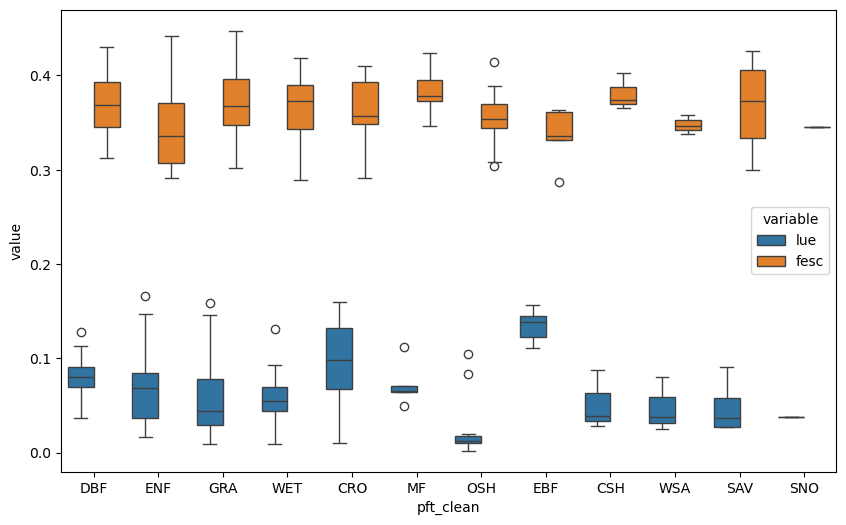

In [101]:
import seaborn as sns

df_melted = pd.melt(df_stat_clean, id_vars="pft_clean", value_vars=["lue", "fesc"])

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x="pft_clean", y="value", hue="variable", data=df_melted)

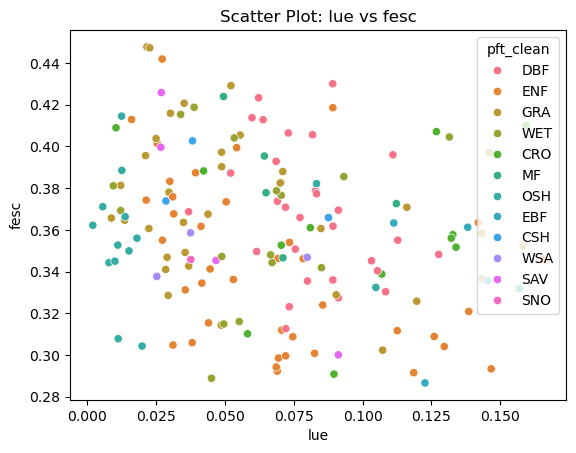

In [102]:
import seaborn as sns

# Create a scatter plot with hue based on pft_clean
sns.scatterplot(data=df_stat_clean, x="lue", y="fesc", hue="pft_clean")

# Set the labels and title
plt.xlabel("lue")
plt.ylabel("fesc")
plt.title("Scatter Plot: lue vs fesc")

# Show the plot
plt.show()

In [115]:
var_list = [
    "gpp",
    "lue",
    "fesc",
    "nirv",
    "nirvp",
    "dasf",
    "ndvi",
    "fpar",
    "par",
    "pft_clean",
]
df_mean = df_stat_clean[var_list].groupby("pft_clean").mean()
df_mean = df_mean.reset_index()
df_mean

,pft_clean,gpp,lue,fesc,nirv,nirvp,dasf,ndvi,fpar,par
0,CRO,6.189860,0.095345,0.361067,0.122202,39.185954,0.124836,0.440007,0.328874,274.437710
1,CSH,4.408556,0.051493,0.380763,0.119279,44.479162,0.121851,0.403785,0.315230,357.124154
2,DBF,6.832669,0.081525,0.368536,0.129737,40.732500,0.132534,0.453515,0.345925,278.459980
3,EBF,6.172873,0.134866,0.335663,0.059326,15.866768,0.060605,0.303957,0.194780,266.527434
4,ENF,2.948867,0.068383,0.341982,0.111906,27.568089,0.114319,0.423747,0.320318,202.757474
5,GRA,4.811878,0.058743,0.372613,0.130802,47.010092,0.133621,0.453045,0.341189,323.835806
6,MF,6.079848,0.072435,0.383204,0.146421,50.613983,0.149577,0.475079,0.374605,294.231680
7,OSH,1.175376,0.023465,0.355487,0.115438,39.950274,0.117926,0.428925,0.318787,312.498915
8,SAV,5.399162,0.047919,0.367673,0.152496,58.002367,0.155783,0.516843,0.394828,391.717177
9,SNO,0.403650,0.037645,0.345757,0.114181,22.329133,0.116642,0.461094,0.328643,169.213708


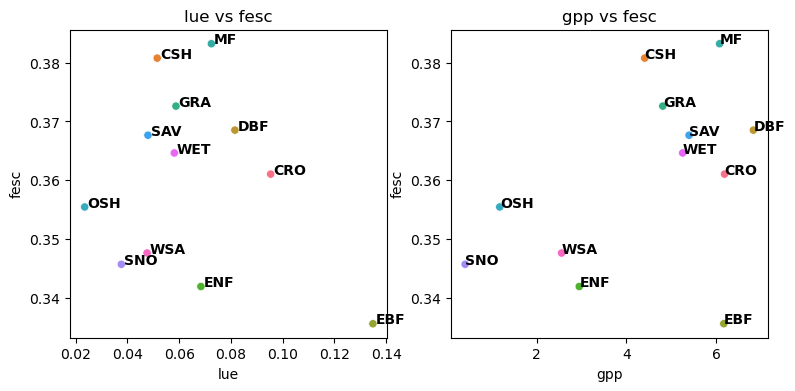

In [117]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

x = "lue"
y = "fesc"

scatter = sns.scatterplot(data=df_mean, x=x, y=y, hue="pft_clean", ax=ax[0])
for line in range(0, df_mean.shape[0]):
    scatter.text(
        df_mean[x][line] + 0.001,
        df_mean[y][line],
        df_mean.pft_clean[line],
        horizontalalignment="left",
        size="medium",
        color="black",
        weight="semibold",
    )

ax[0].set_xlabel(x)
ax[0].set_ylabel(y)
ax[0].set_title(x + " vs " + y)
scatter.legend_.remove()
x = "gpp"
y = "fesc"

scatter = sns.scatterplot(data=df_mean, x=x, y=y, hue="pft_clean", ax=ax[1])
for line in range(0, df_mean.shape[0]):
    scatter.text(
        df_mean[x][line] + 0.001,
        df_mean[y][line],
        df_mean.pft_clean[line],
        horizontalalignment="left",
        size="medium",
        color="black",
        weight="semibold",
    )

ax[1].set_xlabel(x)
ax[1].set_ylabel(y)
ax[1].set_title(x + " vs " + y)

# Remove the legend
scatter.legend_.remove()

plt.savefig("../outputs/figures/all_sites.png")

In [113]:
df_mean = df_mean.set_index("pft_clean")

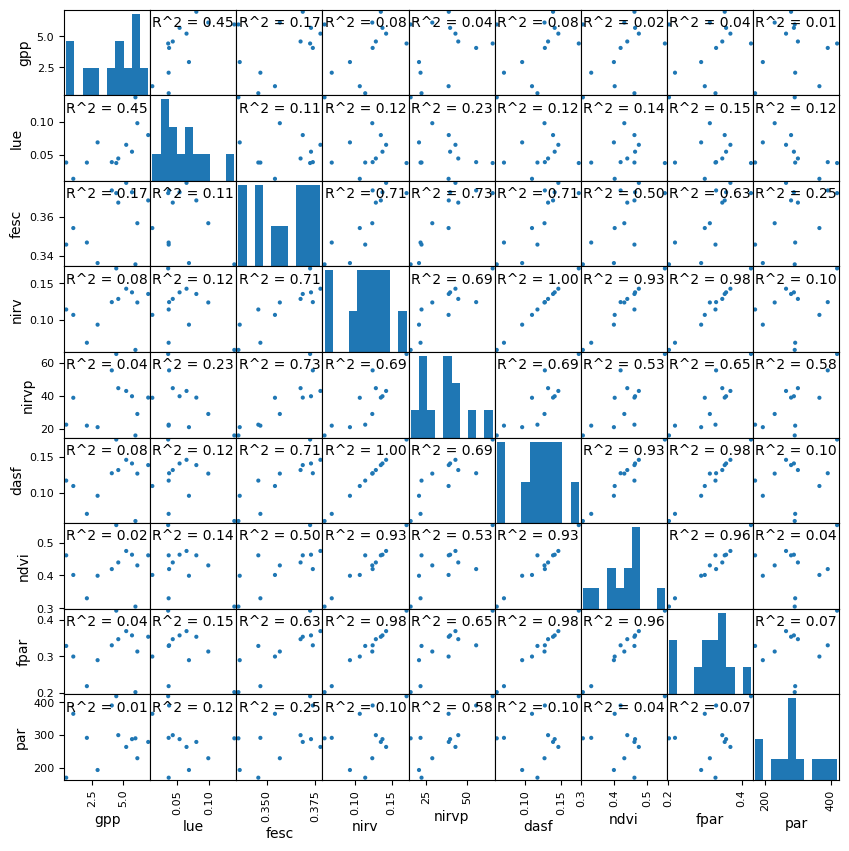

In [114]:
from pandas.plotting import scatter_matrix

axs = scatter_matrix(df_mean, figsize=(10, 10), alpha=1)
# Loop over the diagonal
for i in range(len(df_mean.columns)):
    for j in range(len(df_mean.columns)):
        if i != j:
            # Calculate the R^2 value
            r2 = (
                np.corrcoef(df_mean[df_mean.columns[i]], df_mean[df_mean.columns[j]])[
                    0, 1
                ]
                ** 2
            )
            # Add the R^2 value to the plot
            axs[i, j].annotate(
                "R^2 = {:.2f}".format(r2),
                (0.5, 0.8),
                xycoords="axes fraction",
                ha="center",
            )

### Below code are for time series plot of the data


In [ ]:
# i = 335 # US-Ha1
bad_sites = []

i = 186
site_name = combined_names[i]
site_type = combined_types[i]
print([site_name, site_type])
selected_ec = combined_ec[combined_ec["name"] == site_name]
selected_refl = combined_refl[combined_refl["name"] == site_name]
selected_fpar = combined_fpar[combined_fpar["name"] == site_name]

In [ ]:
if selected_ec["PPFD_IN_QC"].isna().all():
    print("No PPFD data for this site")
    bad_sites.append(site_name)
    # continue

gpp = selected_ec[["GPP_NT_VUT_REF"]]
par = selected_ec[["PPFD_IN"]]
par_qc = selected_ec[["PPFD_IN_QC"]]
ec_daily = pd.concat([gpp, par, par_qc], axis=1).rename(
    columns={"GPP_NT_VUT_REF": "gpp", "PPFD_IN": "par", "PPFD_IN_QC": "par_qc"}
)
ec_daily = ec_daily[ec_daily["par_qc"] == 1]
ec_daily = ec_daily[ec_daily["gpp"] != -9999]
if len(ec_daily) < 30:
    print("Not enough data for this site")
    bad_sites.append(site_name)
    # continue

ec_daily

In [ ]:
# filter fpar based on QC flags
filtered_fpar = selected_fpar[
    (selected_fpar["MCD15A3H_061_FparLai_QC_MODLAND"] == "0b0")
    & (selected_fpar["MCD15A3H_061_FparLai_QC_DeadDetector"] == "0b0")
    & (selected_fpar["MCD15A3H_061_FparLai_QC_CloudState"] == "0b00")
    & (selected_fpar["MCD15A3H_061_FparLai_QC_SCF_QC"].isin(["0b000", "0b001"]))
].copy()

filtered_fpar.loc[:, "time"] = pd.to_datetime(filtered_fpar["Date"])
fpar_4days = filtered_fpar[["MCD15A3H_061_Fpar_500m"]]
fpar_4days.set_index(filtered_fpar["time"], inplace=True)
fpar_daily = fpar_4days.resample("D").interpolate(method="linear")
fpar_daily.rename(columns={"MCD15A3H_061_Fpar_500m": "fpar"}, inplace=True)
if len(fpar_daily) < 30:
    print("Not enough fpar for" + site_name)
    bad_sites.append(site_name)
    # continue
fpar_daily

In [ ]:
# Now filter reflectance
filtered_refl = selected_refl[
    (
        selected_refl["MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band1_MODLAND"]
        == "0b000"
    )
    & (
        selected_refl["MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band2_MODLAND"]
        == "0b000"
    )
    & (
        selected_refl["MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band4_MODLAND"]
        == "0b000"
    )
].copy()
filtered_refl.loc[:, "time"] = pd.to_datetime(filtered_refl["Date"])
red_daily = filtered_refl[["MCD43A4_061_Nadir_Reflectance_Band1"]]
nir_daily = filtered_refl[["MCD43A4_061_Nadir_Reflectance_Band2"]]
green_daily = filtered_refl[["MCD43A4_061_Nadir_Reflectance_Band4"]]

refl_daily = pd.concat([red_daily, nir_daily], axis=1).rename(
    {
        "MCD43A4_061_Nadir_Reflectance_Band1": "red",
        "MCD43A4_061_Nadir_Reflectance_Band2": "nir",
        "MCD43A4_061_Nadir_Reflectance_Band4": "green",
    },
    axis=1,
)
refl_daily.set_index(filtered_refl["time"], inplace=True)
refl_daily

In [ ]:
daily_df = ec_daily.merge(refl_daily, left_index=True, right_index=True).merge(
    fpar_daily, left_index=True, right_index=True
)
daily_df

In [ ]:
daily_df.loc[:, "ndvi"] = (daily_df["nir"] - daily_df["red"]) / (
    daily_df["nir"] + daily_df["red"]
)
daily_df.loc[:, "nirv"] = daily_df["ndvi"] * daily_df["nir"]
daily_df.loc[:, "nirvp"] = daily_df["nirv"] * daily_df["par"]
daily_df.loc[:, "fesc"] = daily_df["nirv"] / daily_df["fpar"]

daily_df.loc[:, "lue"] = daily_df["gpp"] / (daily_df["par"] * daily_df["fpar"])
daily_df = daily_df.replace([-np.inf, np.inf], np.nan).dropna()

In [ ]:
# Calculate Z-scores
z_scores = np.abs(zscore(daily_df))

# Set a threshold for outliers
threshold = 3

# Get a boolean mask where True indicates it is an outlier
outliers = (z_scores > threshold).any(axis=1)

# Remove outliers
daily_df_no_outliers = daily_df[~outliers].copy()
daily_df_no_outliers

In [ ]:
attributes = ["lue", "fesc", "nirv", "nirvp", "ndvi", "gpp"]
scatter_matrix(daily_df_no_outliers[attributes], figsize=(10, 10))
r2_values_daily = {}
attributes = ["lue", "fesc", "nirv", "nirvp", "ndvi", "gpp"]

for x in attributes:
    for y in attributes:
        if x != y:
            slope, intercept, r_value, p_value, std_err = linregress(
                daily_df_no_outliers[x], daily_df_no_outliers[y]
            )
            r2_values_daily[(x, y)] = r_value**2

r2_values_daily

In [ ]:
bad_sites = []

i = 2
site_name = combined_names[i]
site_type = combined_types[i]
print([site_name, site_type])
selected_ec = combined_ec[combined_ec["name"] == site_name]
selected_refl = combined_refl[combined_refl["name"] == site_name]
selected_fpar = combined_fpar[combined_fpar["name"] == site_name]

if selected_ec["PPFD_IN_QC"].isna().all():
    print("No PPFD data for this site")
    bad_sites.append(site_name)
    # continue

gpp = selected_ec[["GPP_NT_VUT_REF"]]
par = selected_ec[["PPFD_IN"]]
par_qc = selected_ec[["PPFD_IN_QC"]]
ec_daily = pd.concat([gpp, par, par_qc], axis=1).rename(
    columns={"GPP_NT_VUT_REF": "gpp", "PPFD_IN": "par", "PPFD_IN_QC": "par_qc"}
)
ec_daily = ec_daily[ec_daily["par_qc"] == 1]
ec_daily = ec_daily[ec_daily["gpp"] != -9999]
if len(ec_daily) < 30:
    print("Not enough data for this site")
    bad_sites.append(site_name)
    # continue

filtered_fpar = selected_fpar[
    (selected_fpar["MCD15A3H_061_FparLai_QC_MODLAND"] == "0b0")
    & (selected_fpar["MCD15A3H_061_FparLai_QC_DeadDetector"] == "0b0")
    & (selected_fpar["MCD15A3H_061_FparLai_QC_CloudState"] == "0b00")
    & (selected_fpar["MCD15A3H_061_FparLai_QC_SCF_QC"].isin(["0b000", "0b001"]))
].copy()

filtered_fpar.loc[:, "time"] = pd.to_datetime(filtered_fpar["Date"])
fpar_4days = filtered_fpar[["MCD15A3H_061_Fpar_500m"]]
fpar_4days.set_index(filtered_fpar["time"], inplace=True)
fpar_daily = fpar_4days.resample("D").interpolate(method="linear")
fpar_daily.rename(columns={"MCD15A3H_061_Fpar_500m": "fpar"}, inplace=True)

filtered_refl = selected_refl[
    (
        selected_refl["MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band1_MODLAND"]
        == "0b000"
    )
    & (
        selected_refl["MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band2_MODLAND"]
        == "0b000"
    )
].copy()
filtered_refl.loc[:, "time"] = pd.to_datetime(filtered_refl["Date"])
red_daily = filtered_refl[["MCD43A4_061_Nadir_Reflectance_Band1"]]
nir_daily = filtered_refl[["MCD43A4_061_Nadir_Reflectance_Band2"]]

refl_daily = pd.concat([red_daily, nir_daily], axis=1).rename(
    {
        "MCD43A4_061_Nadir_Reflectance_Band1": "red",
        "MCD43A4_061_Nadir_Reflectance_Band2": "nir",
    },
    axis=1,
)
refl_daily.set_index(filtered_refl["time"], inplace=True)
daily_df = ec_daily.merge(refl_daily, left_index=True, right_index=True).merge(
    fpar_daily, left_index=True, right_index=True
)

daily_df.loc[:, "ndvi"] = (daily_df["nir"] - daily_df["red"]) / (
    daily_df["nir"] + daily_df["red"]
)
daily_df.loc[:, "nirv"] = daily_df["ndvi"] * daily_df["nir"]
daily_df.loc[:, "nirvp"] = daily_df["nirv"] * daily_df["par"]
daily_df.loc[:, "fesc"] = daily_df["nirv"] / daily_df["fpar"]

daily_df.loc[:, "lue"] = daily_df["gpp"] / (daily_df["par"] * daily_df["fpar"])
attributes = ["lue", "fesc", "nirv", "nirvp", "ndvi", "gpp"]
scatter_matrix(daily_df_no_outliers[attributes], figsize=(10, 10))
r2_values_daily = {}
attributes = ["lue", "fesc", "nirv", "nirvp", "ndvi", "gpp"]

for x in attributes:
    for y in attributes:
        if x != y:
            slope, intercept, r_value, p_value, std_err = linregress(
                daily_df_no_outliers[x], daily_df_no_outliers[y]
            )
            r2_values_daily[(x, y)] = r_value**2

In [ ]:
from scipy.stats import linregress
from pandas.plotting import scatter_matrix
import pandas as pd


def process_site_data(
    i, combined_names, combined_types, combined_ec, combined_refl, combined_fpar
):
    bad_sites = []
    site_name = combined_names[i]
    site_type = combined_types[i]
    selected_ec = combined_ec[combined_ec["name"] == site_name]
    selected_refl = combined_refl[combined_refl["name"] == site_name]
    selected_fpar = combined_fpar[combined_fpar["name"] == site_name]

    if selected_ec["PPFD_IN_QC"].isna().all():
        print("No PPFD data for " + site_name)
        bad_sites.append(site_name)
        return (
            bad_sites,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
        )

    ec_daily = process_ec_data(selected_ec)
    if len(ec_daily) < 30:
        print("Not enough data for " + site_name)
        bad_sites.append(site_name)
        return (
            bad_sites,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
        )

    fpar_daily = process_fpar_data(selected_fpar)
    if len(fpar_daily) < 30:
        print("Not enough fpar for" + site_name)
        bad_sites.append(site_name)
        return (
            bad_sites,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
        )

    refl_daily = process_refl_data(selected_refl)
    if len(refl_daily) < 30:
        print("Not enough reflectance data for " + site_name)
        bad_sites.append(site_name)
        return (
            bad_sites,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
        )

    daily_df = merge_data(ec_daily, refl_daily, fpar_daily)
    if len(daily_df) < 30:
        print("Not enough data for " + site_name)
        bad_sites.append(site_name)
        return (
            bad_sites,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
        )
    daily_df = calculate_indices(daily_df)
    daily_df = daily_df.replace([-np.inf, np.inf], np.nan).dropna()
    daily_df_no_outliers = remove_outliers(
        daily_df
    )  # Assuming you have a way to remove outliers

    r2_values_daily, p_value_daily = calculate_r2_values(daily_df_no_outliers)

    weekly_df = daily_df_no_outliers.resample("W").mean()
    weekly_df_no_outliers = remove_outliers(weekly_df)
    weekly_df_no_outliers.dropna(inplace=True)
    r2_values_weekly, p_value_weekly = calculate_r2_values(weekly_df_no_outliers)

    monthly_df = daily_df_no_outliers.resample("M").mean()
    monthly_df_no_outliers = remove_outliers(monthly_df)
    monthly_df_no_outliers.dropna(inplace=True)
    r2_values_monthly, p_value_monthly = calculate_r2_values(monthly_df_no_outliers)

    return (
        bad_sites,
        r2_values_daily,
        p_value_daily,
        r2_values_weekly,
        p_value_weekly,
        r2_values_monthly,
        p_value_monthly,
        daily_df_no_outliers,
        weekly_df_no_outliers,
        monthly_df_no_outliers,
        site_type,
        site_name,
    )


def process_ec_data(selected_ec):
    gpp = selected_ec[["GPP_NT_VUT_REF"]]
    par = selected_ec[["PPFD_IN"]]
    par_qc = selected_ec[["PPFD_IN_QC"]]
    ec_daily = pd.concat([gpp, par, par_qc], axis=1).rename(
        columns={"GPP_NT_VUT_REF": "gpp", "PPFD_IN": "par", "PPFD_IN_QC": "par_qc"}
    )
    ec_daily = ec_daily[ec_daily["par_qc"] == 1]
    ec_daily = ec_daily[ec_daily["gpp"] != -9999]
    return ec_daily


def process_fpar_data(selected_fpar):
    # Your code here
    # filter fpar based on QC flags
    filtered_fpar = selected_fpar[
        (selected_fpar["MCD15A3H_061_FparLai_QC_MODLAND"] == "0b0")
        & (selected_fpar["MCD15A3H_061_FparLai_QC_DeadDetector"] == "0b0")
        & (selected_fpar["MCD15A3H_061_FparLai_QC_CloudState"] == "0b00")
        & (selected_fpar["MCD15A3H_061_FparLai_QC_SCF_QC"].isin(["0b000", "0b001"]))
    ].copy()

    filtered_fpar.loc[:, "time"] = pd.to_datetime(filtered_fpar["Date"])
    fpar_4days = filtered_fpar[["MCD15A3H_061_Fpar_500m"]]
    fpar_4days.set_index(filtered_fpar["time"], inplace=True)
    fpar_daily = fpar_4days.resample("D").interpolate(method="linear")
    fpar_daily.rename(columns={"MCD15A3H_061_Fpar_500m": "fpar"}, inplace=True)
    return fpar_daily


def process_refl_data(selected_refl):
    # Your code here
    filtered_refl = selected_refl[
        (
            selected_refl[
                "MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band1_MODLAND"
            ]
            == "0b000"
        )
        & (
            selected_refl[
                "MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band2_MODLAND"
            ]
            == "0b000"
        )
    ].copy()
    filtered_refl.loc[:, "time"] = pd.to_datetime(filtered_refl["Date"])
    red_daily = filtered_refl[["MCD43A4_061_Nadir_Reflectance_Band1"]]
    nir_daily = filtered_refl[["MCD43A4_061_Nadir_Reflectance_Band2"]]

    refl_daily = pd.concat([red_daily, nir_daily], axis=1).rename(
        {
            "MCD43A4_061_Nadir_Reflectance_Band1": "red",
            "MCD43A4_061_Nadir_Reflectance_Band2": "nir",
        },
        axis=1,
    )
    refl_daily.set_index(filtered_refl["time"], inplace=True)
    return refl_daily


def merge_data(ec_daily, refl_daily, fpar_daily):
    # Your code here
    daily_df = ec_daily.merge(refl_daily, left_index=True, right_index=True).merge(
        fpar_daily, left_index=True, right_index=True
    )
    return daily_df


def calculate_indices(daily_df):
    # w_nir = 0.9789
    # w_green = 0.4898
    daily_df.loc[:, "ndvi"] = (daily_df["nir"] - daily_df["red"]) / (
        daily_df["nir"] + daily_df["red"]
    )
    daily_df.loc[:, "nirv"] = daily_df["ndvi"] * daily_df["nir"]
    daily_df.loc[:, "nirvp"] = daily_df["nirv"] * daily_df["par"]
    daily_df.loc[:, "fesc"] = daily_df["nirv"] / daily_df["fpar"]
    # daily_df.loc[:, "p"] = (
    #     (daily_df["nir"] / w_nir) - (daily_df["green"] / w_green)
    # ) / (daily_df["nir"] - daily_df["green"])
    daily_df.loc[:, "lue"] = daily_df["gpp"] / (daily_df["par"] * daily_df["fpar"])
    return daily_df


def remove_outliers(df):
    # Your code here
    z_scores = np.abs(zscore(df))

    # Set a threshold for outliers
    threshold = 2

    # Get a boolean mask where True indicates it is an outlier
    outliers = (z_scores > threshold).any(axis=1)

    # Remove outliers
    df_no_outliers = df[~outliers].copy()
    return df_no_outliers


def calculate_r2_values(df):
    r2_values = {}
    p_values = {}
    attributes = ["lue", "fesc", "nirv", "nirvp", "ndvi", "gpp"]
    for x in attributes:
        for y in attributes:
            if x != y:
                slope, intercept, r_value, p_value, std_err = linregress(df[x], df[y])
                r2_values[(x, y)] = r_value**2
                p_values[(x, y)] = p_value
    return (r2_values, p_value)

In [ ]:
i = 106  # US-Ha1
# i = 186
(
    bad_sites,
    r2_values_daily,
    p_value_daily,
    r2_values_weekly,
    p_value_weekly,
    r2_values_monthly,
    p_value_monthly,
    daily_df_no_outliers,
    weekly_df_no_outliers,
    monthly_df_no_outliers,
    site_type,
    site_name,
) = process_site_data(
    i, combined_names, combined_types, combined_ec, combined_refl, combined_fpar
)
site_name, r2_values_monthly

In [ ]:
bad_sites_list = []
good_sites_data = []

# Loop through sites
for i in range(len(combined_names)):
    print(i)
    (
        bad_sites,
        r2_values_daily,
        p_value_daily,
        r2_values_weekly,
        p_value_weekly,
        r2_values_monthly,
        p_value_monthly,
        daily_df_no_outliers,
        weekly_df_no_outliers,
        monthly_df_no_outliers,
        site_type,
        site_name,
    ) = process_site_data(
        i, combined_names, combined_types, combined_ec, combined_refl, combined_fpar
    )

    if len(bad_sites) > 0:
        bad_sites_list.extend(bad_sites)
    else:
        good_sites_data.append(
            {
                "Site Name": site_name,
                "Site Type": site_type,
                "R2 Values daily": r2_values_daily,
                "p Values daily": p_value_daily,
                "R2 Values weekly": r2_values_weekly,
                "p Values weekly": p_value_weekly,
                "R2 Values monthly": r2_values_monthly,
                "p Values monthly": p_value_monthly,
                "daily_df_no_outliers": daily_df_no_outliers,
                "weekly_df_no_outliers": weekly_df_no_outliers,
                "monthly_df_no_outliers": monthly_df_no_outliers,
            }
        )

In [ ]:
import seaborn as sns

# Create a DataFrame from good_sites_data
df = pd.DataFrame(good_sites_data)

# Extract R2 values into a separate DataFrame
r2_df = pd.DataFrame(df["R2 Values weekly"].tolist())
r2_df["Site Name"] = df["Site Name"]
r2_df["Site Type"] = df["Site Type"]
# Melt the DataFrame to a long format
melted_df = r2_df.melt(
    id_vars=["Site Name", "Site Type"], var_name="Pair", value_name="R2"
)
selected_pairs = [("lue", "fesc"), ("lue", "nirv"), ("lue", "nirvp")]
filtered_df = melted_df[melted_df["Pair"].isin(selected_pairs)]
sns.boxplot(data=filtered_df, x="Site Type", y="R2", hue="Pair")
plt.savefig("../outputs/all_sites_weekly_r2.png")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame from good_sites_data
df = pd.DataFrame(good_sites_data)

# Extract R2 values into a separate DataFrame
r2_df = pd.DataFrame(df["R2 Values weekly"].tolist())
r2_df["Site Name"] = df["Site Name"]
r2_df["Site Type"] = df["Site Type"]

# Melt the DataFrame to a long format
melted_df = r2_df.melt(
    id_vars=["Site Name", "Site Type"], var_name="Pair", value_name="R2"
)
selected_pairs = [("lue", "fesc"), ("lue", "nirv"), ("lue", "nirvp")]
filtered_df = melted_df[melted_df["Pair"].isin(selected_pairs)]

# Create boxplot
ax = sns.boxplot(data=filtered_df, x="Site Type", y="R2", hue="Pair")

# Annotate number of samples in each boxplot
for i, site_type in enumerate(filtered_df["Site Type"].unique()):
    # Select one of the pairs, for example "lue", "fesc"
    pair = selected_pairs[0]
    num_samples = len(
        filtered_df[
            (filtered_df["Site Type"] == site_type) & (filtered_df["Pair"] == pair)
        ]
    )
    max_y = filtered_df[
        (filtered_df["Site Type"] == site_type) & (filtered_df["Pair"] == pair)
    ]["R2"].max()
    ax.text(
        i,
        max_y + 0.01,
        f"n={num_samples}",
        horizontalalignment="center",
        size="small",
        color="black",
        weight="semibold",
    )

plt.savefig("../outputs/all_sites_weekly_r2.png")

In [ ]:
# Concatenate all 'daily_df_no_outliers' DataFrames into one
all_daily_df = pd.concat(
    [
        df.loc[i, "daily_df_no_outliers"].assign(site_type=df.loc[i, "Site Type"])
        for i in df.index
    ]
)
print("Number of daily data points:", len(all_daily_df))
print("Number of sites:", len(df))

In [ ]:
from scipy.stats import zscore

all_daily_df_no_outlier = all_daily_df[
    (np.abs(zscore(all_daily_df["lue"])) < 2) | (all_daily_df["lue"].isna())
]
all_daily_df_no_outlier

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=all_daily_df_no_outlier, x="site_type", y="fesc")

# Annotate number of samples in each boxplot
for i, site_type in enumerate(all_daily_df_no_outlier["site_type"].unique()):
    num_samples = len(
        all_daily_df_no_outlier[all_daily_df_no_outlier["site_type"] == site_type]
    )
    max_y = all_daily_df_no_outlier[all_daily_df_no_outlier["site_type"] == site_type][
        "lue"
    ].max()
    ax.text(
        i,
        max_y - 0.01,
        f"n={num_samples}",
        horizontalalignment="center",
        size="small",
        color="black",
        weight="semibold",
    )

plt.title("Boxplot of LUE for each Site Type")
plt.savefig("../outputs/lue_boxplot.png")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=all_daily_df_no_outlier, x="site_type", y="fpar")

# # Annotate number of samples in each boxplot
# for i, site_type in enumerate(all_daily_df_no_outlier["site_type"].unique()):
#     num_samples = len(all_daily_df_no_outlier[all_daily_df_no_outlier["site_type"] == site_type])
#     max_y = all_daily_df_no_outlier[all_daily_df_no_outlier["site_type"] == site_type]["fpar"].max()
#     ax.text(i, max_y - 0.01, f'n={num_samples}', horizontalalignment='center', size='small', color='black', weight='semibold')

plt.title("Boxplot of fpar for each Site Type")
plt.savefig("../outputs/fpar_boxplot.png")

In [ ]:
# Create dictionaries mapping site names to latitude and longitude
ameriflux_dict = ameriflux_info.set_index("Site ID")[
    ["Latitude (degrees)", "Longitude (degrees)"]
].to_dict(orient="index")
fluxnet_dict = fluxnet_info.set_index("ID")[["lat", "lon"]].to_dict(orient="index")

# Initialize an empty list to store the latitude and longitude values
lat_lon_list = []

# Loop through each row in the DataFrame
for index, row in df.iterrows():
    # Extract site name from the row
    site_name = row["Site Name"]

    # Get latitude and longitude from ameriflux_dict if it exists, otherwise get it from fluxnet_dict
    if site_name in ameriflux_dict:
        lat = ameriflux_dict[site_name]["Latitude (degrees)"]
        lon = ameriflux_dict[site_name]["Longitude (degrees)"]
    elif site_name in fluxnet_dict:
        lat = fluxnet_dict[site_name]["lat"]
        lon = fluxnet_dict[site_name]["lon"]
    else:
        lat = None
        lon = None

    # Append the latitude and longitude to the list
    lat_lon_list.append({"Site Name": site_name, "Latitude": lat, "Longitude": lon})

# Create a DataFrame from the list of latitude and longitude values
lat_lon_df = pd.DataFrame(lat_lon_list)

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# Convert DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(lat_lon_df["Longitude"], lat_lon_df["Latitude"])]
geo_df = gpd.GeoDataFrame(lat_lon_df, geometry=geometry)

# Set the GeoDataFrame's coordinate system to geographic (EPSG:4326)
geo_df.set_crs("EPSG:4326", inplace=True)

# Save the GeoDataFrame as a GeoJSON file
geo_df.to_file("../outputs/lat_lon.geojson", driver="GeoJSON")